# Amazon Food Reviews Analysis : Data Wrangling


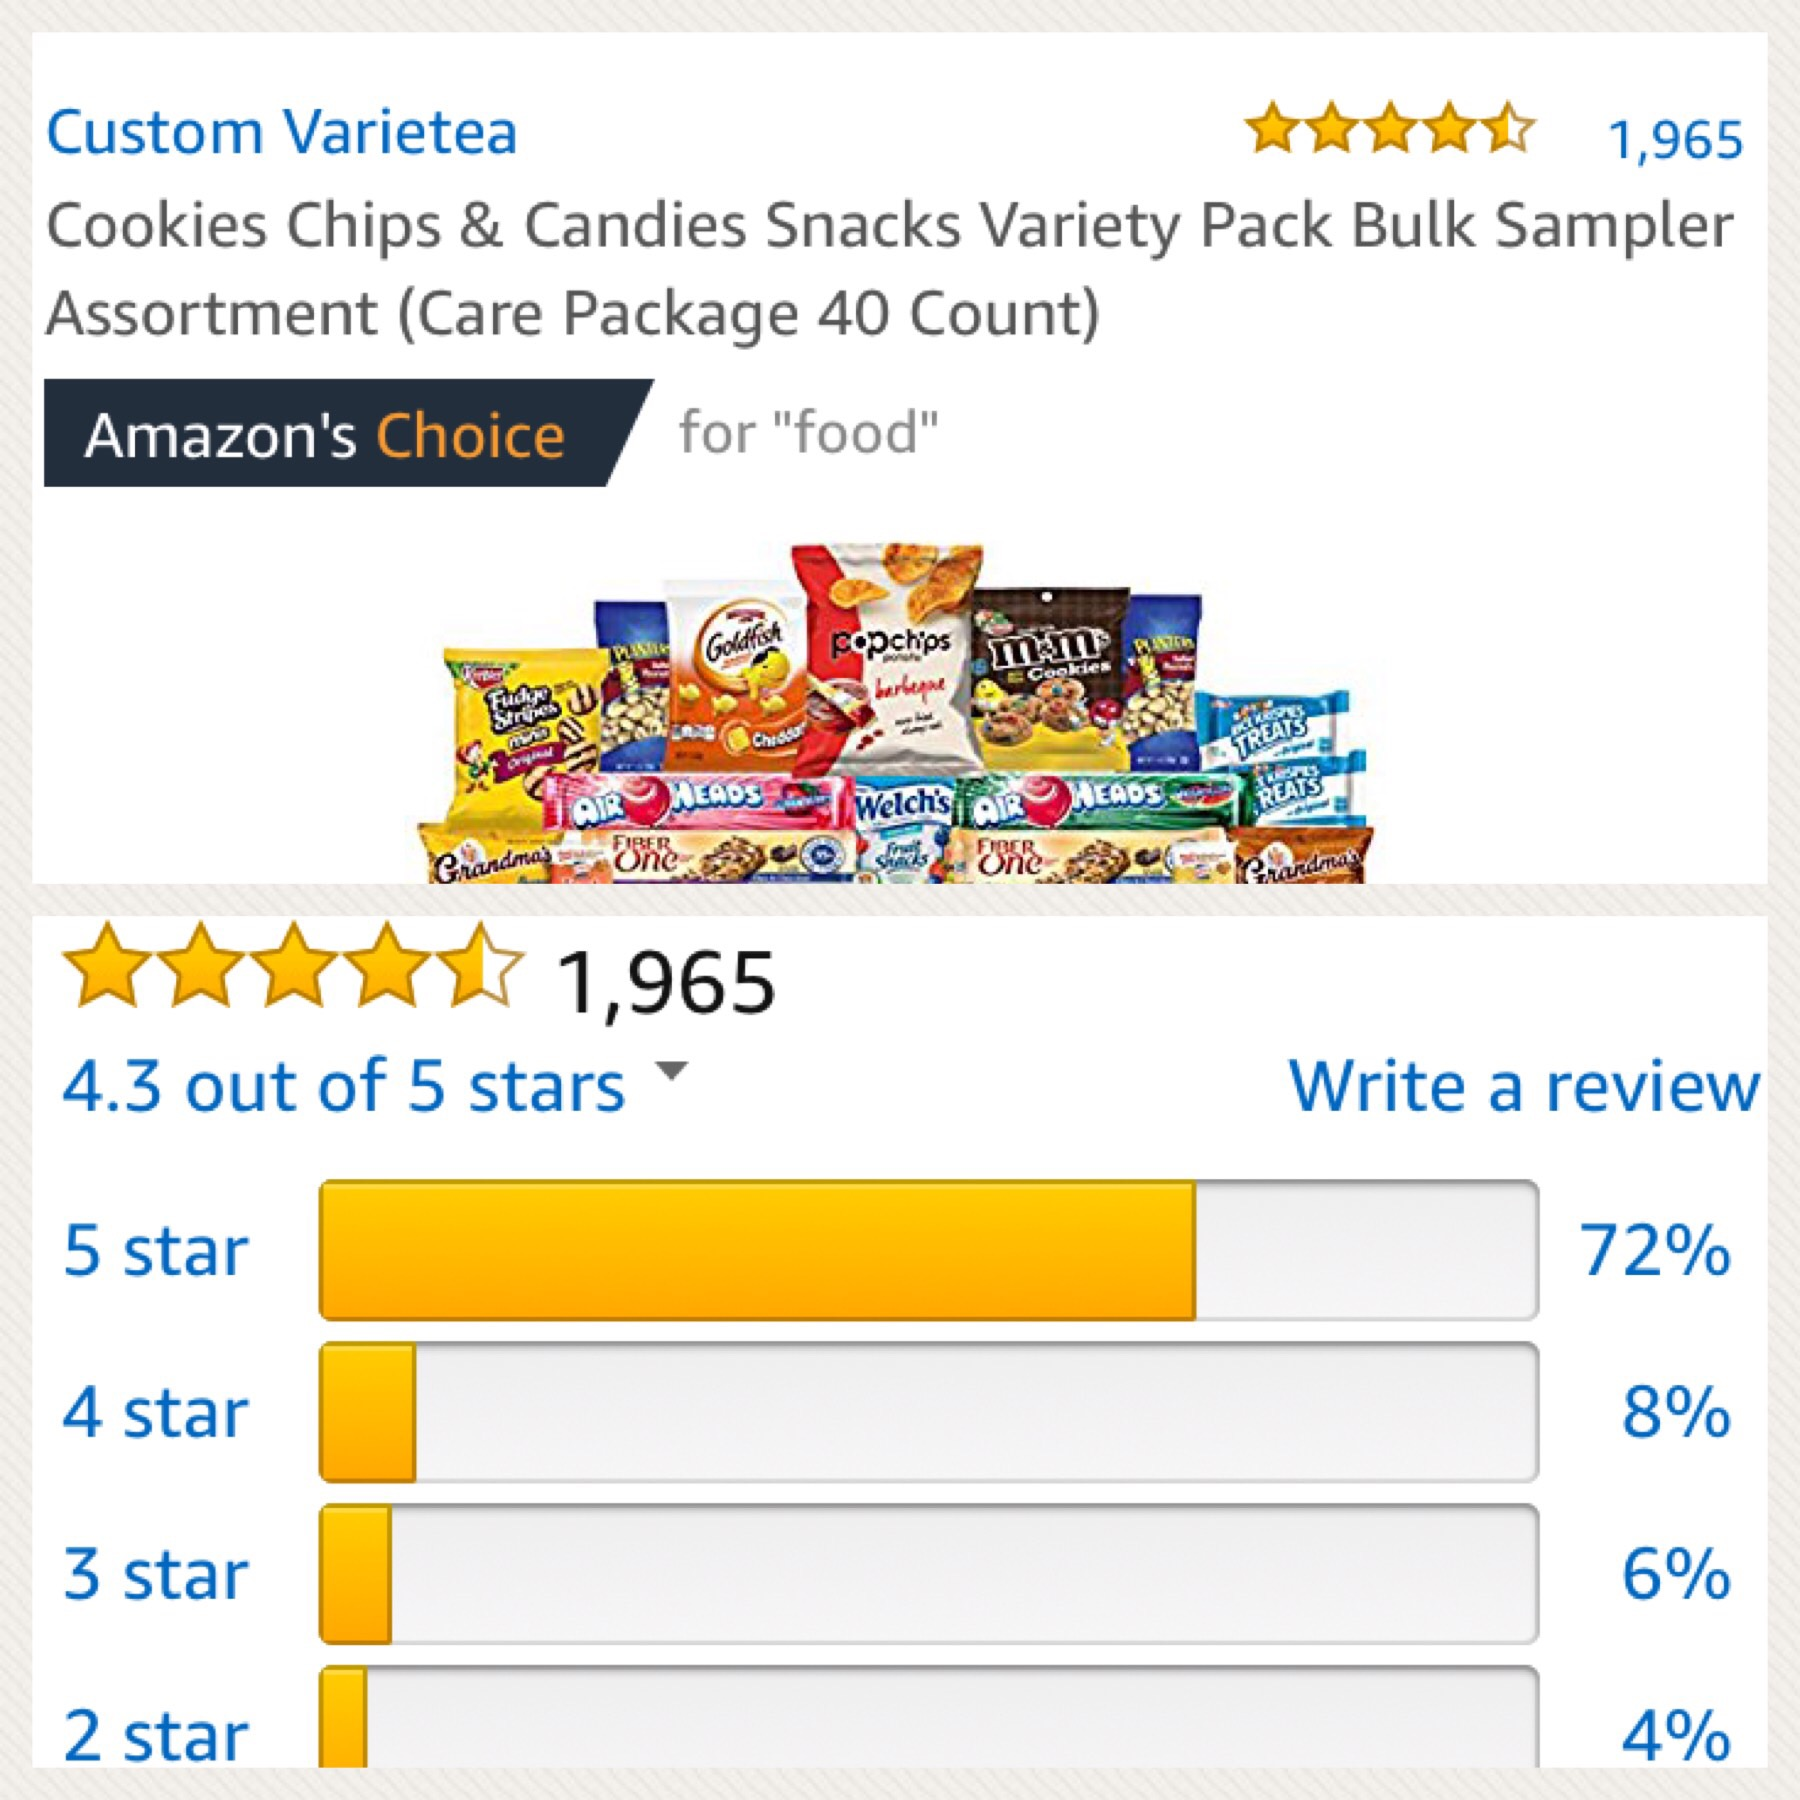

In [1]:
from IPython.display import Image
Image(filename='amazon.png')
Image(filename='IMG_3294.JPG')

### How often do you shop on Amazon ?<br> <br> Have you ever hesitated to buy something if you see a negative reivew ? <br> <br> After you read some positive reviews, you decide to buy the product and then notice the reviews are categorized as "not helpful," will this change your decision about purchasing the product?

# Project Overview 

Background: Recently more and more Amazon sellers realized how customers’ reviews can impact other buyers’ decision making. Since most of customers will hesitate to make a purchase decision if the product has a negative review.  As an analyst, my goal is to help the business to provide the good shopping experience. So, I want to develop the model to predict if a review is helpful or not helpful from sentiment analysis.  Then the modeling outcome will help Amazon’s merchants have better understand about customers’ attitudes towards reviews.<br>

The purpose of this analysis is to build a prediction model where we will be able to predict whether a review is helpful or notheful.

In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame, datetime
from subprocess import check_output
from datetime import datetime, timedelta, time
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as cm
import seaborn as sns

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

def display (text, title):
    print(title)
    print("\n-----------------\n")
    print(text)

# 1. Data Preparation 

## Clean Numeric Data
+ Clean missing value
+ Check duplicate 
+ Find out some interesting EDA

In [3]:
amazon = pd.read_csv('Reviews.csv',index_col=0)
amazon.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


+ Id
+ ProductId - unique identifier for the product
+ UserId - unqiue identifier for the user
+ ProfileName
+ HelpfulnessNumerator - number of users who found the review helpful
+ HelpfulnessDenominator - number of users who indicated whether they found the review helpful
+ Score - rating between 1 and 5
+ Time - timestamp for the review
+ Summary - brief summary of the review
+ Text - text of the review

In [4]:
#check number of observations and row
print (amazon.shape)

(568454, 9)


In [5]:
#check missing value 
amazon.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

In [6]:
# Since majority of data has value, we can just remove missing values
amazon= amazon.dropna(subset=['ProfileName','Summary'])
amazon.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [7]:
#check number of observations and row after removed missing value
print (amazon.shape)

(568412, 9)


In [8]:
# covert time
amazon['date_time']=pd.to_datetime(amazon['Time'],unit='s')
amazon['date']=pd.to_datetime(amazon['date_time'],unit='d')
amazon['date1'] = pd.to_datetime(amazon['date'])
amazon['year']=amazon.date1.dt.year
amazon.date_time.describe()

count                  568412
unique                   3168
top       2012-10-16 00:00:00
freq                     1143
first     1999-10-08 00:00:00
last      2012-10-26 00:00:00
Name: date_time, dtype: object

In [9]:
# check HelpfulnessDenominator
amazon.HelpfulnessDenominator.describe()

count    568412.000000
mean          2.227872
std           8.288745
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         923.000000
Name: HelpfulnessDenominator, dtype: float64

In [10]:
# check percentage of Helpful
amazon['Helpful_pct'] = amazon['HelpfulnessNumerator'] / amazon['HelpfulnessDenominator']
amazon.loc[amazon.HelpfulnessDenominator==0,'Helpful_pct']=0
amazon['Helpful_pct'].describe()

count    568412.000000
mean          0.407883
std           0.462073
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: Helpful_pct, dtype: float64

In [11]:
# divided the reviews into four categories
def partition(x):
    if x >=0.75:
        return '75'
    elif x>=0.5:
        return '50'
    elif x>=0.25 :
        return '25'
    return '0'
amazon['help1'] = amazon['Helpful_pct'].map(partition)
amazon['help1'].describe()

count     568412
unique         4
top            0
freq      308295
Name: help1, dtype: object

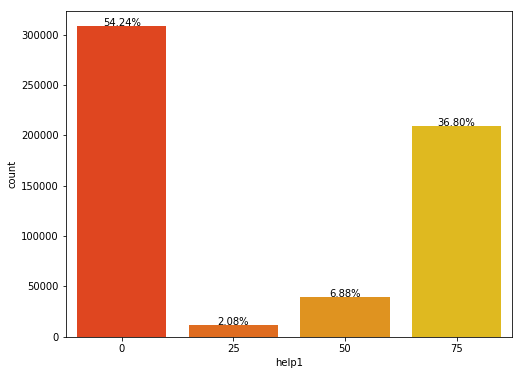

In [12]:
plt.figure(figsize=(8,6))
total = float(len(amazon)) 
ax = sns.countplot(x="help1",palette='autumn', data=amazon) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

#### Among all reviews, more then 50% are not voted on at all. More than 35% of voters find the review helpful.

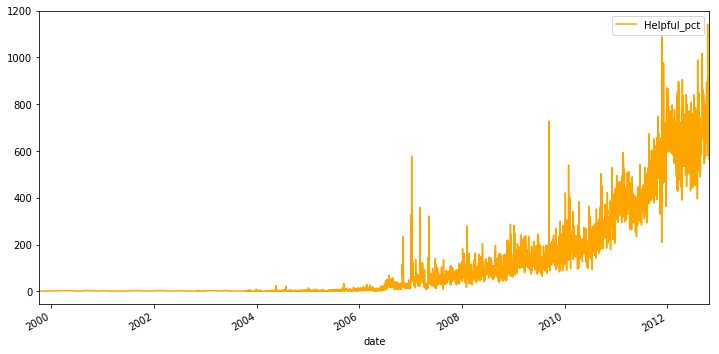

In [13]:
## Helpfulness count, reviews has increased 
time1=amazon[['date','Helpful_pct']].copy()
time1['Helpful_pct']=amazon.groupby(['date']).Helpful_pct.transform('count')
time1.set_index(['date'],inplace=True)
time1.sort_index(inplace=True)
time1.plot(color='orange',figsize=(12,6))
plt.show()

#### 1. After remove missing value the dataset contains 568,412 food reviews from Amazon users left from 1999 Oct to 2012 Oct. <BR> 2. Reviews has increased over years.

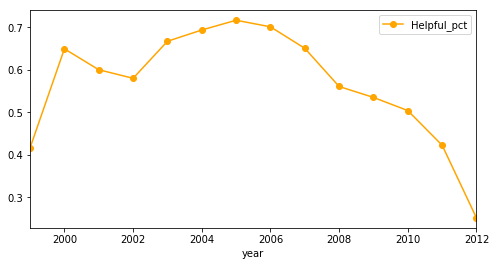

In [14]:
avg_help_pct=amazon.groupby(['year']).Helpful_pct.mean().reset_index().sort_values(by='year')
avg_help_pct.plot(x='year',y='Helpful_pct',marker='o', color='orange',figsize=(8,4))
plt.show()

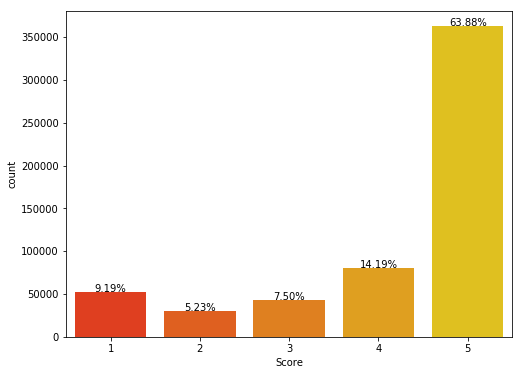

In [15]:
plt.figure(figsize=(8,6))
total = float(len(amazon)) 
ax = sns.countplot(amazon['Score'],color="orange",palette='autumn') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

In [16]:
print("Average Score: ",np.mean(amazon.Score))
print("Median Score: ",np.median(amazon.Score))

Average Score:  4.183307178595808
Median Score:  5.0


#### The distribution of rating among all of the reviews. We see that 5-star reviews constitute a large proportion (64%) of all reviews. The next most prevalent rating is 4-stars(14%), followed by 1-star (9%), 3-star (8%), and finally 2-star reviews (5%). Majority of Scores are around 4 to 5, and average score is 4.18. The distribution is very skewed to the left. 

#### Summary of dataset statistics 
+ Number of reviews : 393,566
+ Number of unique users : 256,048 
+ Number of unique products :74,258

In [17]:
review= amazon['UserId'].groupby(amazon['Text']).count()
print(review.count())
User= amazon['Score'].groupby(amazon['UserId']).count()
print(User.count())
products = amazon['Score'].groupby(amazon['ProductId']).count()
print(products.count())

393566
256048
74258


In [18]:
amazon['chk']=amazon.duplicated(['Text'])
amazon['chk'].sum()

174846

## Cleaning Text
+ Lower case 
+ Removing punctuation and stopwords
+ Text visualization

In [19]:
from bs4 import BeautifulSoup 
from scipy.misc import imread
from PIL import Image
import numpy as np
import re
import matplotlib as mpl
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
chk1=amazon["Text"][26]
display(chk1,'sample check')

sample check

-----------------

Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>


In [33]:
amazon["Text"].iloc[27]

'I was so glad Amazon carried these batteries.  I have a hard time finding them elsewhere because they are such a unique size.  I need them for my garage door opener.<br />Great deal for the price.'

In [34]:
def clean_text1(text, remove_stopwords = True):
    '''Remove stopwords'''
    
    # Convert words to lower case
    text = text.lower()
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    return text

In [35]:
amazon["Summary1"] = amazon["Summary"].apply(clean_text1)

In [36]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [37]:
c_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [76]:
sample=amazon["Text"][29]
expandContractions(sample)

'I got this for my Mum who is not diabetic but needs to watch her sugar intake, and my father who simply chooses to limit unnecessary sugar intake - she is the one with the sweet tooth - they both LOVED these toffees, you would never guess that they are sugar-free and it is so great that you can eat them pretty much guilt free!  i was so impressed that i have ordered some for myself (w dark chocolate) to take to the office so i will eat them instead of snacking on sugary sweets.<br />These are just EXCELLENT!'

In [38]:
amazon["text_Clean1"] = amazon["Text"].apply(expandContractions)

In [41]:
lemmatizer = nltk.WordNetLemmatizer()
stemmer = PorterStemmer()
stop = stopwords.words('english')
def clean_text2(line):
    tokens=[]
    line= BeautifulSoup(line, 'html.parser').get_text()
    line= re.sub(r'\<a href', ' ', line)
    line= re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', line)
    line= re.sub(r'&amp;', '', line) 
    line= re.sub(r"\'s", " is", line)
    line= nltk.word_tokenize(line.lower())
    for w in line:
        if(w not in stop):
#             stemmed = stemmer.stem(w)
            stemmed = lemmatizer.lemmatize(w)
            tokens.append(stemmed)
    return ' '.join(tokens)

In [42]:
amazon["text_Clean2"] = amazon["text_Clean1"].apply(clean_text2)

In [45]:
chk2=amazon["text_Clean2"][30]
display(chk2,'sample check')

sample check

-----------------

know cactus tequila unique combination ingredient flavour hot sauce make one kind picked bottle trip brought back home u totally blown away realized simply could find anywhere city bummed magic internet case sauce ecstatic love hot sauce mean really love hot sauce want sauce tastelessly burn throat grab bottle tequila picante gourmet de inclan realize taste never want use sauce thank personal incredible service


In [89]:
amazon["text_Clean2"].iloc[28]

'got mum diabetic need watch sugar intake father simply chooses limit unnecessary sugar intake one sweet tooth loved toffee would never guess sugar free great eat pretty much guilt free impressed ordered w dark chocolate take office eat instead snacking sugary sweet excellent'

In [46]:
amazon["word_cnt"] = amazon['Text'].str.split().str.len()
amazon["word_cnt"].describe()

count    568412.000000
mean         80.267303
std          79.457074
min           3.000000
25%          33.000000
50%          56.000000
75%          98.000000
max        3432.000000
Name: word_cnt, dtype: float64

#### Each reivew contains approximately 80 words.

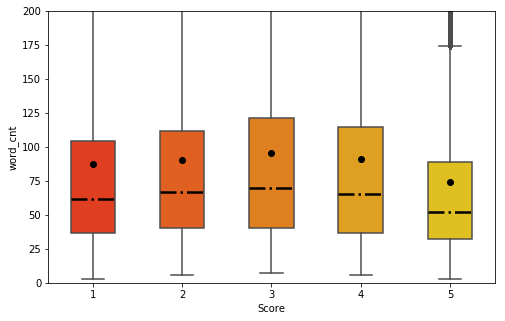

In [63]:
medianprops = dict(linestyle='-.', linewidth=2.5, color='black')
meanprops = dict(linestyle='none', marker='o', markerfacecolor='black',markeredgecolor='black')
plt.figure(figsize=(8,5))
plt.ylim(0, 200)
# Change line width
sns.boxplot( x=amazon["Score"], y=amazon["word_cnt"], showmeans=True, meanprops=meanprops, medianprops=medianprops, width=0.5,palette='autumn')
plt.show()

#### 5-star reviews had the lowest median word count and 3-star reviews had the largest median word count.

In [58]:
# save clean data 
amazon.to_csv('amazon_clean.csv')

## Word cloud for all reviews

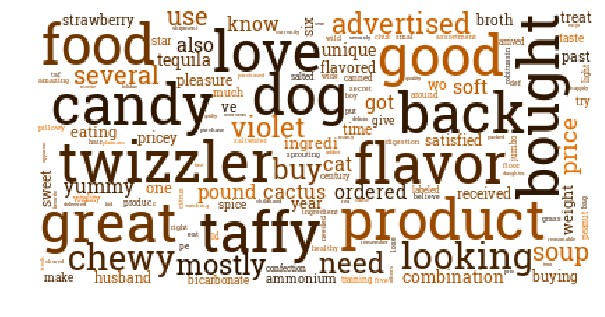

In [157]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(20, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

from collections import Counter
import random
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from os import path
import os
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        font_path=os.path.join('fonts', 'RobotoSlab-Regular.ttf'),
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        color_func=random_color_func
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(10, 6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
#     plt.imshow(wordcloud.)
show_wordcloud(amazon["text_Clean2"]) 

## Low Score reviews word cloud 

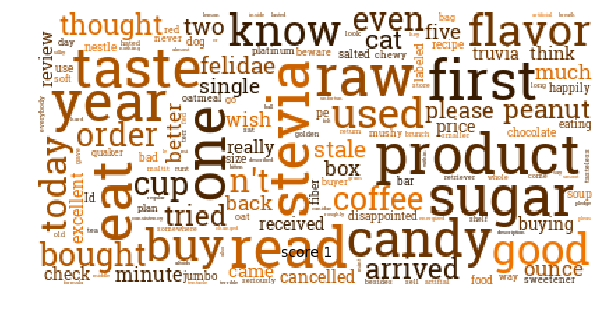

In [158]:
show_wordcloud(amazon[amazon.Score == 1]["text_Clean2"], title = "score 1")

## High Score reviews word cloud

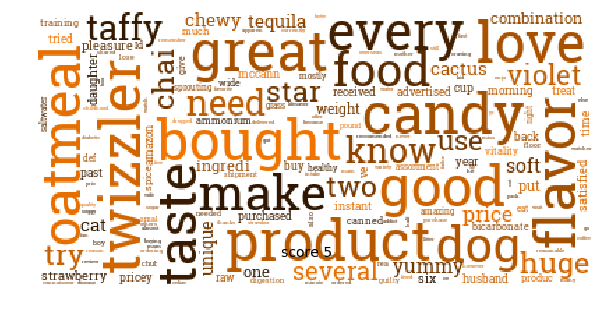

In [159]:
show_wordcloud(amazon[amazon.Score == 5]["text_Clean2"], title = "score 5")

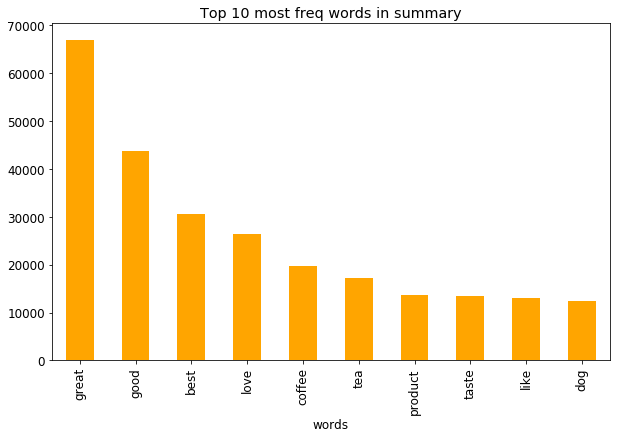

In [121]:
word_his = pd.DataFrame(Counter(" ".join(amazon['Summary1']).split()).most_common(10),columns=['words','count'])
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 10 most freq words in summary',figsize=(10,6), color="orange")
plt.show()

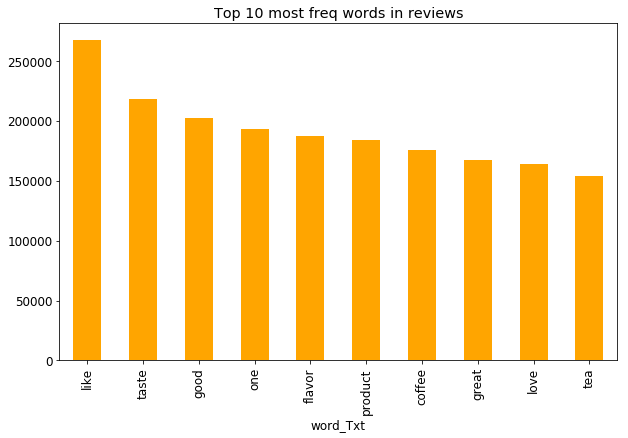

In [122]:
word_Txt_his = pd.DataFrame(Counter(" ".join(amazon['text_Clean2']).split()).most_common(10),columns=['word_Txt','count'])
word_Txt_his.plot(kind='bar',x=word_Txt_his['word_Txt'],legend=False,title='Top 10 most freq words in reviews',figsize=(10,6), color="orange")
plt.show()

#### Further analysis : <br> Does the behavior of frequent reviewers differ from that of infrequent reviewers?